# Setting


> Imports



In [ ]:
import os
import math
import numpy as np
from numpy import array
from numpy import hstack
import pandas as pd
import netCDF4
import xarray as xr
import pickle
import tensorflow as tf
import seaborn as sns

import keras
from keras import layers, losses, regularizers
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.models import Model, load_model
from keras.layers import Input, Dense, Flatten, Reshape, LeakyReLU, Cropping2D, RepeatVector, TimeDistributed, LSTM

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, roc_curve, auc, precision_recall_curve

import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline



> Check GPU



> Connect to Google drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/My Drive/')
os.getcwd()

# if not os.path.exists('JULES'):
#         os.makedirs('JULES')


'/content/drive/My Drive'


> Download the monthly data from 1961-1900 in advance and deposit it in the cloud folder. The required data is extracted through ``Data_preprocessing.ipynb``and then stored in the **JULES** folder.



# Convolutional Autoencoder



## Data preparing




> READ the data from csv


In [ ]:
gb_df = pd.read_csv('JULES/gb_data.csv', index_col=0)
gb_data = gb_df.values
print(gb_data.shape)

gb_df2 = pd.read_csv('JULES/gb_data2.csv', index_col=0)
gb_data2 = gb_df2.values
print(gb_data2.shape)

gb_df3 = pd.read_csv('JULES/gb_data3.csv', index_col=0)
gb_data3 = gb_df3.values
print(gb_data3.shape)

gb_df4 = pd.read_csv('JULES/gb_data4.csv', index_col=0)
gb_data4 = gb_df4.values
print(gb_data4.shape)

gb_df5 = pd.read_csv('JULES/gb_data5.csv', index_col=0)
gb_data5 = gb_df5.values
print(gb_data5.shape)


(360, 21504)
(360, 21504)
(360, 21504)
(360, 21504)
(360, 21504)




> Normalize the interval of the data to 0-1



In [ ]:
scaler = preprocessing.MinMaxScaler()
gb_data = scaler.fit_transform(gb_data)
gb_data = np.array(gb_data, dtype = np.float32)

scaler2 = preprocessing.MinMaxScaler()
gb_data2 = scaler2.fit_transform(gb_data2)
gb_data2 = np.array(gb_data2, dtype = np.float32)

scaler3 = preprocessing.MinMaxScaler()
gb_data3 = scaler3.fit_transform(gb_data3)
gb_data3 = np.array(gb_data3, dtype = np.float32)

scaler4 = preprocessing.MinMaxScaler()
gb_data4 = scaler4.fit_transform(gb_data4)
gb_data4 = np.array(gb_data4, dtype = np.float32)

scaler5 = preprocessing.MinMaxScaler()
gb_data5 = scaler5.fit_transform(gb_data5)
gb_data5 = np.array(gb_data5, dtype = np.float32)




> Check the normalization



In [ ]:
print(np.max(gb_data))
print(np.mean(gb_data))
print(np.min(gb_data))


1.0
0.01690674
0.0




> RESHAPE the data that suitable for the learnning model

> **(sample_number, row_number, column_number, channel)**


In [ ]:
gb_data = np.reshape(gb_data, (360, 112, 192, 1))
print(gb_data.shape)
gb_data2 = np.reshape(gb_data2, (360, 112, 192, 1))
print(gb_data2.shape)
gb_data3 = np.reshape(gb_data3, (360, 112, 192, 1))
print(gb_data3.shape)

gb_data4 = np.reshape(gb_data4, (360, 112, 192, 1))
print(gb_data4.shape)
gb_data5 = np.reshape(gb_data5, (360, 112, 192, 1))
print(gb_data5.shape)


(360, 112, 192, 1)
(360, 112, 192, 1)
(360, 112, 192, 1)
(360, 112, 192, 1)
(360, 112, 192, 1)




> Splitting the data into training, validation and testing set （5 : 1 : 2）


In [ ]:
total_gb_data = []
total_gb_data.extend(gb_data)
total_gb_data.extend(gb_data2)
total_gb_data.extend(gb_data3)
total_gb_data = np.array(total_gb_data)
print(total_gb_data.shape)


(1080, 112, 192, 1)


In [ ]:
newarr = np.array_split(total_gb_data, 6)
cae_train = np.vstack((newarr[0], newarr[1], newarr[2], newarr[3], newarr[4]))
cae_test = gb_data4
cae_val = newarr[5]

print(cae_train.shape)
print(cae_val.shape)
print(cae_test.shape)

cae_train = cae_train.astype('float32') # 75 years
cae_val = cae_val.astype('float32') # 15 years
cae_test = cae_test.astype('float32') # 30 years


(900, 112, 192, 1)
(180, 112, 192, 1)
(360, 112, 192, 1)




## CAE Model




> Define the Convolutional Autoencoder network


In [ ]:
def my_encoder_model(input_img):
  act_f = str("relu")# relu

  x = layers.Conv2D(64, (15, 20), activation= act_f, padding='same')(input_img)
  x = layers.MaxPooling2D((2, 2), padding='same')(x)
  x = layers.Conv2D(32, (10, 15), activation= act_f, padding='same')(x)
  x = layers.MaxPooling2D((2, 2), padding='same')(x)
  x = layers.Conv2D(16, (5, 10), activation= act_f, padding='same')(x)
  x = layers.MaxPooling2D((2, 2), padding='same')(x)
  
  x = Flatten()(x)
  x = LeakyReLU(alpha=0.3)(x)
  x = Dense(400, activation= act_f)(x)
  x = LeakyReLU(alpha=0.3)(x)
  encoded = Dense(100, activation= act_f)(x)

  return encoded

def my_decoder_model(encoded):
  act_f = str("relu") # relu

  x = Dense(100, activation= act_f)(encoded)
  x = LeakyReLU(alpha=0.3)(x)
  x = Dense(400, activation= act_f)(x)
  x = LeakyReLU(alpha=0.3)(x)
  x = Reshape((16, 25, 1))(x)

  
  x = layers.Conv2D(16, (5, 10), activation= act_f, padding='same')(x)
  x = layers.UpSampling2D((2, 2))(x)
  x = layers.Conv2D(32, (10, 15), activation= act_f, padding='same')(x)
  x = layers.UpSampling2D((2, 2))(x)
  x = layers.Conv2D(64, (15, 20), activation= act_f, padding='same')(x)
  x = layers.UpSampling2D((2, 2))(x)
  x = Cropping2D(cropping=((16, 0), (8, 0)), data_format=None)(x)
  decoded = layers.Conv2D(1, (15,20), activation='sigmoid', padding='same')(x)
  return decoded




> Construct the Autoencoder network



In [ ]:
# input shape
input_img = keras.Input(shape=(112, 192, 1))
# for the encoeded data
encoded = my_encoder_model(input_img)
print(encoded.shape)
# for the encoded data
decoded = my_decoder_model(encoded)
print(decoded.shape)

# combine the encode and decode parts as autoencoder
autoencoder = keras.Model(input_img, decoded)

layer_number = 13
# this model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)
# this model maps the encoded representation to the original representation
encoded_input = Input(shape=(100,))
decoder = autoencoder.layers[-layer_number](encoded_input)
for i in range(layer_number-1):
  decoder = autoencoder.layers[i-layer_number+1](decoder)
decoder = keras.Model(encoded_input, decoder)

autoencoder.summary()
autoencoder.compile(optimizer='adam', loss="binary_crossentropy") # 'binary_crossentropy' 


(None, 100)
(None, 112, 192, 1)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 112, 192, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 112, 192, 64)      19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 96, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 96, 32)        307232    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 48, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           

In [ ]:
encoder.summary()
decoder.summary()



> Plot the variation of loss with epochs


In [ ]:

font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 14,
}

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.val_loss['batch'].append(logs.get('val_loss'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.val_loss['epoch'].append(logs.get('val_loss'))

    def loss_plot(self, loss_type, fname):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type, font1)
        plt.ylabel('loss', font1)
        plt.legend(loc="upper right")
        plt.yscale('log')
        plt.savefig('output_figure/'+str(fname)+'.png')
        plt.show()




> Train the Convolutional Autoencoder model



In [ ]:
history = LossHistory()
autoencoder.fit(cae_train, cae_train,
                epochs=1000,
                batch_size=128, 
                shuffle=True, 
                callbacks=[history], validation_data=(cae_val, cae_val))


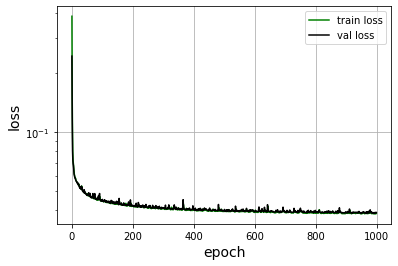

In [ ]:
# Draw acc-loss plots
history.loss_plot('epoch',"cae_loss_train_100") # np.log()



> Save the trained model data



In [ ]:
# from keras.models import save_model
# autoencoder.save("JULES/autoencoder_p_100.h5")


> Load the trained model data

In [ ]:
from keras.models import load_model
autoencoder = load_model("JULES/autoencoder_p_100.h5")


In [ ]:
autoencoder.summary()



> Construct the encoder and decoder with the loaded model



In [ ]:
input_img = keras.Input(shape=(112, 192, 1))
layer_number = 12


encoder = autoencoder.layers[0](input_img)
for i in range(layer_number):
  encoder = autoencoder.layers[i+1](encoder)
encoder = keras.Model(input_img, encoder)

# this model maps the encoded representation to the original representation
encoded_input = Input(shape=(100,))
decoder = autoencoder.layers[-layer_number](encoded_input)
for i in range(layer_number-1):
  decoder = autoencoder.layers[i-layer_number+1](decoder)
decoder = keras.Model(encoded_input, decoder)



## CAE Model Testing



In [ ]:
p4 = autoencoder.predict(cae_test)
print(p4.shape)
p5 = autoencoder.predict(gb_data5)
print(p5.shape)


(360, 112, 192, 1)
(360, 112, 192, 1)


In [ ]:
d4 = p4-cae_test
print(d4.shape)
d5 = p5-gb_data5
print(d5.shape)


(360, 112, 192, 1)
(360, 112, 192, 1)




> CHECK MSE



In [ ]:
# check mse

def check_mse(comp, original):
  total_mse = []
  for i in range(comp.shape[0]):
    this_mse = np.linalg.norm(comp[i]-original[i]) / (112*192)
    total_mse.append(this_mse)
  total_mse2 = np.array(total_mse)
  print("The average MSE is ", np.mean(total_mse2))
  # print(total_mse2.shape)
  x = range(len(total_mse))
  plt.scatter(x, total_mse, alpha=0.6)
  plt.show()
  return np.mean(total_mse2), total_mse2


In [ ]:
# compare mse

def check_mse_comp(pca, pca_original, cae, cae_original,fname):
  pca_mse = []
  cae_mse = []
  for i in range(pca.shape[0]):
    this_pca_mse = np.linalg.norm(pca[i]-pca_original[i]) / (112*192)
    this_cae_mse = np.linalg.norm(cae[i]-cae_original[i]) / (112*192)
    pca_mse.append(this_pca_mse)
    cae_mse.append(this_cae_mse)
  pca_mse2 = np.array(pca_mse)
  cae_mse2 = np.array(cae_mse)
  print("The average MSE with PCA is ", np.mean(pca_mse2))
  print("The average MSE with CAE is ", np.mean(cae_mse2))
  x = range(len(pca_mse))
  plt.scatter(x, pca_mse, alpha=0.6, label='PCA')
  plt.scatter(x, cae_mse, alpha=0.6, label='CAE')
  plt.ylabel('MSE', font1)
  plt.xlabel('Samples',font1)
  plt.legend()
  plt.savefig('output_figure/'+str(fname)+'.png',bbox_inches='tight')
  plt.show()
  return np.mean(pca_mse2), np.mean(cae_mse2)
  



> Compare with PCA



The average MSE is  0.0001760236110486504


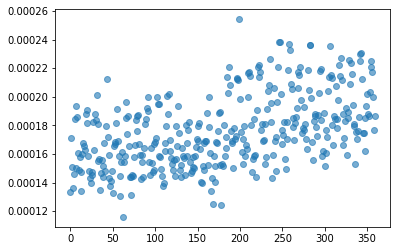

In [ ]:
pca_train = np.reshape(cae_train, (900, 21504))
pca_test = np.reshape(cae_test, (360, 21504))
pca = PCA(n_components=100)
pca.fit(pca_train)
encode_test = pca.transform(pca_test)
reconTest = pca.inverse_transform(encode_test)
_,__ = check_mse(reconTest, pca_test)


The average MSE is  0.00016373602815696764


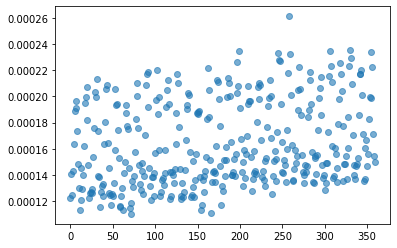

In [ ]:
av_cae4, cae_mse4 = check_mse(p4, cae_test)

The average MSE is  0.00016583950451585076


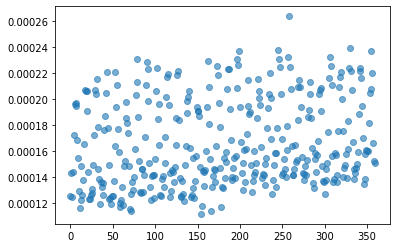

In [ ]:
av_cae5, cae_mse5 = check_mse(p5, gb_data5)


The average MSE with PCA is  0.0001760236110486504
The average MSE with CAE is  0.00016373602021115997


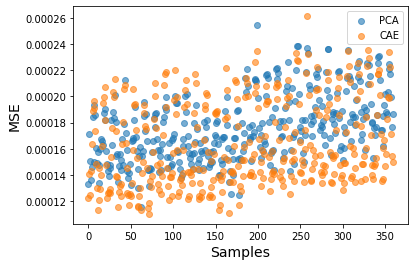

(0.0001760236110486504, 0.00016373602021115997)

In [ ]:
check_mse_comp(reconTest, pca_test, p4, cae_test,'pca_cae_100')


# LSTM



## Prepare the Climate data





> Load the trained autoencoder models for temperature, precipitation, humidity, lighting



> The CAE models for climate conditions are generated by these files.



```
JULES_CAE_tair.ipynb
JULES_CAE_rain.ipynb
JULES_CAE_qair.ipynb
JULES_CAE_lightning.ipynb
```





In [ ]:
from keras.models import load_model
autoencoder_tair = load_model('JULES/para_mod/autoencoder_tair.h5')
autoencoder_rain = load_model('JULES/para_mod/autoencoder_rain.h5')
autoencoder_qair = load_model('JULES/para_mod/autoencoder_qair.h5')
autoencoder_lightning = load_model('JULES/para_mod/autoencoder_lightning.h5')

input_img = keras.Input(shape=(144, 192, 1))
layer_number = 14

encoder_tair = autoencoder_tair.layers[0](input_img)
encoder_qair = autoencoder_qair.layers[0](input_img)
encoder_rain = autoencoder_rain.layers[0](input_img)
encoder_lightning = autoencoder_lightning.layers[0](input_img)

for i in range(layer_number):
  encoder_tair = autoencoder_tair.layers[i+1](encoder_tair)
  encoder_rain = autoencoder_rain.layers[i+1](encoder_rain)
  encoder_qair = autoencoder_qair.layers[i+1](encoder_qair)
  encoder_lightning = autoencoder_lightning.layers[i+1](encoder_lightning)
encoder_tair = keras.Model(input_img, encoder_tair)
encoder_rain = keras.Model(input_img, encoder_rain)
encoder_qair = keras.Model(input_img, encoder_qair)
encoder_lightning = keras.Model(input_img, encoder_lightning)

# # this model maps the encoded representation to the original representation
# encoded_input = Input(shape=(20,))
# decoder_tair = autoencoder_tair.layers[-layer_number](encoded_input)
# for i in range(layer_number-1):
#   decoder_tair = autoencoder_tair.layers[i-layer_number+1](decoder_tair)
# decoder_tair = keras.Model(encoded_input, decoder_tair)





> Split the climate data into two part for validation data



In [ ]:
def sp_climate_data (climate_data, kind):
  newarr = np.array_split(climate_data, 2)
  cae_tair_train = newarr[0]
  cae_tair_val = newarr[1]

  cae_tair_train = np.reshape(cae_tair_train, (180, 144, 192, 1))
  cae_tair_val = np.reshape(cae_tair_val, (180, 144, 192, 1))

  if (kind == 1):
    cae_tair_train = encoder_tair.predict(cae_tair_train)
    cae_tair_val = encoder_tair.predict(cae_tair_val)
  elif (kind == 2):
    cae_tair_train = encoder_rain.predict(cae_tair_train)
    cae_tair_val = encoder_rain.predict(cae_tair_val)
  elif (kind == 3):
    cae_tair_train = encoder_qair.predict(cae_tair_train)
    cae_tair_val = encoder_qair.predict(cae_tair_val)
  elif (kind == 4):
    cae_tair_train = encoder_lightning.predict(cae_tair_train)
    cae_tair_val = encoder_lightning.predict(cae_tair_val)
  return cae_tair_train, cae_tair_val
  


> Encoede the Climate data respectively




1.   Temperature - tair



In [ ]:
# load the data
tair_df = pd.read_csv('JULES/tair.csv', index_col=0)
tair_data = tair_df.values
tair_data[np.isnan(tair_data)] = 0
# normalization the data
min_max_scaler_tair = preprocessing.MinMaxScaler()
tair_data = min_max_scaler_tair.fit_transform(tair_data)
tair_data = np.array(tair_data, dtype = np.float32)

# encode the data
train_data_tair, val_data_tair= sp_climate_data(tair_data, 1)
# re-normalizartion
train_tair = preprocessing.MinMaxScaler()
train_data_tair = train_tair.fit_transform(train_data_tair)
val_tair = preprocessing.MinMaxScaler()
val_data_tair = val_tair.fit_transform(val_data_tair)

# encode and re-normalization
tair_data = np.reshape(tair_data, (360, 144, 192, 1))
tair_data = encoder_tair.predict(tair_data)
test_tair = preprocessing.MinMaxScaler()
tair_data = test_tair.fit_transform(tair_data)

print(train_data_tair.shape)
print(val_data_tair.shape)
print(tair_data.shape)


(180, 20)
(180, 20)
(360, 20)


In [ ]:
rain_df = pd.read_csv('JULES/rain.csv', index_col=0)
rain_data = rain_df.values
rain_data[np.isnan(rain_data)] = -0.001
min_max_scaler_rain = preprocessing.MinMaxScaler()
rain_data = min_max_scaler_rain.fit_transform(rain_data)
rain_data = np.array(rain_data, dtype = np.float32)

train_data_rain, val_data_rain = sp_climate_data(rain_data, 2)
train_rain = preprocessing.MinMaxScaler()
train_data_rain = train_rain.fit_transform(train_data_rain)
val_rain = preprocessing.MinMaxScaler()
val_data_rain = val_rain.fit_transform(val_data_rain)

rain_data = np.reshape(rain_data, (360, 144, 192, 1))
rain_data = encoder_rain.predict(rain_data)
test_rain = preprocessing.MinMaxScaler()
rain_data = test_rain.fit_transform(rain_data)

print(train_data_rain.shape)
print(val_data_rain.shape)
print(rain_data.shape)


(180, 20)
(180, 20)
(360, 20)


In [ ]:
qair_df = pd.read_csv('JULES/qair.csv', index_col=0)
qair_data = qair_df.values
qair_data[np.isnan(qair_data)] = -0.001
min_max_scaler_qair = preprocessing.MinMaxScaler()
qair_data = min_max_scaler_tair.fit_transform(qair_data)
qair_data = np.array(qair_data, dtype = np.float32)


train_data_qair, val_data_qair = sp_climate_data(qair_data, 3)
train_qair = preprocessing.MinMaxScaler()
train_data_qair = train_qair.fit_transform(train_data_qair)
val_qair = preprocessing.MinMaxScaler()
val_data_qair = val_qair.fit_transform(val_data_qair)

qair_data = np.reshape(qair_data, (360, 144, 192, 1))
qair_data = encoder_qair.predict(qair_data)
test_qair = preprocessing.MinMaxScaler()
qair_data = test_qair.fit_transform(qair_data)

print(train_data_qair.shape)
print(val_data_qair.shape)
print(qair_data.shape)


(180, 20)
(180, 20)
(360, 20)


In [ ]:
lightning_df = pd.read_csv('JULES/lightning.csv', index_col=0)
lightning_data = lightning_df.values
min_max_scaler_lightning = preprocessing.MinMaxScaler()
lightning_data = min_max_scaler_tair.fit_transform(lightning_data)
lightning_data = np.array(lightning_data, dtype = np.float32)

train_data_lightning, val_data_lightning = sp_climate_data(lightning_data, 4)
train_lightning = preprocessing.MinMaxScaler()
train_data_lightning = train_lightning.fit_transform(train_data_lightning)
val_lightning = preprocessing.MinMaxScaler()
val_data_lightning = val_lightning.fit_transform(val_data_lightning)

lightning_data = np.reshape(lightning_data, (360, 144, 192, 1))
lightning_data = encoder_lightning.predict(lightning_data)
test_lightning = preprocessing.MinMaxScaler()
lightning_data = test_lightning.fit_transform(lightning_data)

print(train_data_lightning.shape)
print(val_data_lightning.shape)
print(lightning_data.shape)


(180, 20)
(180, 20)
(360, 20)


## Prepare the fire data



> Encode and re-normalise the fire data


In [ ]:
# half for training, half for validation
HP3 = np.array_split(gb_data3, 2)
p3_h = newarr[0]
p3_t = newarr[1]

# encoode
train_gb1 = encoder.predict(gb_data)
train_gb2 = encoder.predict(gb_data2)
train_gb3 = encoder.predict(p3_h)
val_data_gb = encoder.predict(p3_t)
test_data_gb = encoder.predict(gb_data4)
test_data5_gb = encoder.predict(gb_data5)

# re-normalization
sc_gb1 = preprocessing.MinMaxScaler()
train_gb1 = sc_gb1.fit_transform(train_gb1)
sc_gb2 = preprocessing.MinMaxScaler()
train_gb2 = sc_gb2.fit_transform(train_gb2)
sc_gb3 = preprocessing.MinMaxScaler()
train_gb3 = sc_gb3.fit_transform(train_gb3)

val_gb = preprocessing.MinMaxScaler()
val_data_gb = val_gb.fit_transform(val_data_gb)
test_gb = preprocessing.MinMaxScaler()
test_data_gb = test_gb.fit_transform(test_data_gb)

test_gb5 = preprocessing.MinMaxScaler()
test_data5_gb = test_gb5.fit_transform(test_data5_gb)

print(train_gb1.shape)
print(train_gb2.shape)
print(train_gb3.shape)
print(val_data_gb.shape)
print(test_data_gb.shape)
print(test_data5_gb.shape)


(360, 100)
(360, 100)
(180, 100)
(180, 100)
(360, 100)
(360, 100)


## Joint the fire and climate data



> A method that can joint the fire and climate data for subsequent LSTM training



In [ ]:
def join_data(gb, tair, rain, qair, lightning):
  join_data = np.zeros((gb.shape[0],100+20*4))
  for i in range(gb.shape[0]):
    coj = []
    coj.extend(gb[i])
    coj.extend(tair[i])
    coj.extend(rain[i])
    coj.extend(qair[i])
    coj.extend(lightning[i])
    coj = np.array(coj)
    coj = np.reshape(coj, (180))
    join_data[i] = coj
  return join_data
  

In [ ]:
train_data1 = join_data(train_gb1,tair_data,rain_data,qair_data,lightning_data)
print(train_data1.shape)
train_data2 = join_data(train_gb2,tair_data,rain_data,qair_data,lightning_data)
print(train_data2.shape)
train_data3 = join_data(train_gb3,train_data_tair,train_data_rain,train_data_qair,train_data_lightning)
print(train_data3.shape)

val_data = join_data(val_data_gb,val_data_tair,val_data_rain,val_data_qair,val_data_lightning)
print(val_data.shape)

test_data = join_data(test_data_gb,tair_data,rain_data,qair_data,lightning_data)
print(test_data.shape)
test_data5 = join_data(test_data5_gb,tair_data,rain_data,qair_data,lightning_data)
print(test_data5.shape)


(360, 180)
(360, 180)
(180, 180)
(180, 180)
(360, 180)
(360, 180)


## Process the data for LSTM training



> Data preprocessing and Data enhencement



In [ ]:
def split_test(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i*12 + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i*12:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# 12 seq predict next 12 seq
n_steps_in, n_steps_out = 12, 12

x_train1, y_train1 = split_sequences(train_data1, n_steps_in, n_steps_out)
print(x_train1.shape, y_train1.shape)
x_train2, y_train2 = split_sequences(train_data2, n_steps_in, n_steps_out)
print(x_train2.shape, y_train2.shape)
x_train3, y_train3 = split_sequences(train_data3, n_steps_in, n_steps_out)
print(x_train3.shape, y_train3.shape)

x_val, y_val = split_sequences(val_data, n_steps_in, n_steps_out)
print(x_val.shape, y_val.shape)

x_test, y_test = split_test(test_data, n_steps_in, n_steps_out)
print(x_test.shape, y_test.shape)
x_test5, y_test5 = split_test(test_data5, n_steps_in, n_steps_out)
print(x_test5.shape, y_test5.shape)

# print (x_test[0], y_test[0])


(337, 12, 180) (337, 12, 180)
(337, 12, 180) (337, 12, 180)
(157, 12, 180) (157, 12, 180)
(157, 12, 180) (157, 12, 180)
(29, 12, 180) (29, 12, 180)
(29, 12, 180) (29, 12, 180)


In [ ]:
x_train = np.vstack((x_train1, x_train2, x_train3))
y_train = np.vstack((y_train1, y_train2, y_train3))
print(x_train.shape, y_train.shape)


(831, 12, 180) (831, 12, 180)


## LSTM Model



> Construct the LSTM Model



In [ ]:
def my_LSTM(n_steps_in, n_steps_out, n_features):
  model = keras.Sequential()
  model.add(LSTM(64, activation='relu', input_shape=(n_steps_in, n_features)))
  model.add(RepeatVector(n_steps_out))
  model.add(LSTM(64, activation='relu', return_sequences=True))
  model.add(Dense(100))
  model.add(LeakyReLU(alpha=0.3))
  model.add(TimeDistributed(Dense(n_features)))
  model.compile(optimizer='adam', loss='mse')
  return model
  



> Train the LSTM Model



In [ ]:
lstm_history = LossHistory()
n_features = x_train.shape[2]
lstm_model = my_LSTM(12, 12, n_features)
lstm_model.fit(x_train, y_train, epochs=10000, verbose=1, callbacks=[lstm_history], validation_data =(x_val, y_val))


In [ ]:
# Draw acc-loss plots
lstm_history.loss_plot('epoch', "cae_lstm_loss_train_100")



> Save the trained LSTM model



In [ ]:
# from keras.models import save_model
# lstm_model.save("JULES/lstm_cae_model_100.h5")




> Load the trained LSTM model



In [ ]:
lstm_model = load_model('JULES/lstm_cae_model_100.h5')


In [ ]:
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                62720     
                                                                 
 repeat_vector_1 (RepeatVect  (None, 12, 64)           0         
 or)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 12, 64)            33024     
                                                                 
 dense_6 (Dense)             (None, 12, 100)           6500      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 12, 100)           0         
                                                                 
 time_distributed_1 (TimeDis  (None, 12, 180)          18180     
 tributed)                                            

## LSTM model testing


### Prepare the Testing data



> Prepare the testing data




In [ ]:
rest_test_data = np.zeros((29, 12, 180))
first_test_data = np.zeros((1, 12, 180))
first_test_data = x_test[0]
first_test_data = np.reshape(first_test_data, (1, 12, 180))
rest_test_data = y_test

print(rest_test_data.shape)
print(first_test_data.shape)


(29, 12, 180)
(1, 12, 180)


In [ ]:
rest_test_data5 = np.zeros((29, 12, 180))
first_test_data5 = np.zeros((1, 12, 180))
first_test_data5 = x_test5[0]
first_test_data5 = np.reshape(first_test_data5, (1, 12, 180))
rest_test_data5 = y_test5

print(rest_test_data5.shape)
print(first_test_data5.shape)




(29, 12, 180)
(1, 12, 180)




> The original data for latter comparison



In [ ]:
original_test_data = np.zeros((348, 112, 192, 1))
for i in range(348):
  original_test_data[i] = cae_test[i+12]
print(original_test_data.shape)


(348, 112, 192, 1)


In [ ]:
original_test_data5 = np.zeros((348, 112, 192, 1))
for i in range(348):
  original_test_data5[i] = gb_data5[i+12]
print(original_test_data5.shape)



(348, 112, 192, 1)


### Without Data Assimilation



> Iterative prediction



In [ ]:
def inner_prediction(input_year):
  this_year = lstm_model.predict(input_year, verbose=0)
  return this_year

def y_mse(comp, original):
  total_mse = []
  for i in range(comp.shape[0]):
    this_mse = np.linalg.norm(comp[i]-original[i]) / (112*192)
    total_mse.append(this_mse)
  total_mse2 = np.array(total_mse)
  return np.mean(total_mse2)

def iterative_prediction(first_year, label_years, original_data, begin_year):
  times = label_years.shape[0]
  predict_years = np.zeros((times, 12, 180))
  this_year = first_year
  for i in range(times):
    this_year = inner_prediction(this_year)
    predict_years[i] = this_year[0]
  y_predict = np.reshape(predict_years, (12*times, 180))
  prediction = y_predict[:,:100]
  prediction = test_gb.inverse_transform(prediction)
  y_decode = decoder.predict(prediction)

  year_mse = []
  pred_year = np.array_split(y_decode, times)
  ori_year = np.array_split(original_data, times)

  for j in range(times):
    this_year_mse = y_mse(pred_year[j], ori_year[j])
    year_mse.append(this_year_mse)
  x = list(range(begin_year+1, begin_year+times+1))
  # plt.scatter(x, year_mse, alpha=0.6)
  plt.plot(x, year_mse,'bo-', alpha=0.4)
  plt.title("The average mse for each predicted year (100 Latent Space)")
  plt.xlabel("Years")
  plt.ylabel("Average year mse for prediction")
  plt.show()
  return y_decode, np.mean(year_mse), year_mse


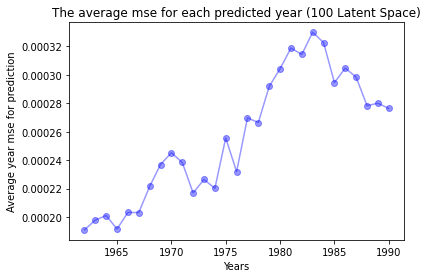

The average mse with testing data4 of prediction is:  0.00025622002008333873


In [ ]:
y_decode4, average_mse4, test_mse4 = iterative_prediction(first_test_data, rest_test_data, original_test_data, 1961)
print("The average mse with testing data4 of prediction is: ", average_mse4)


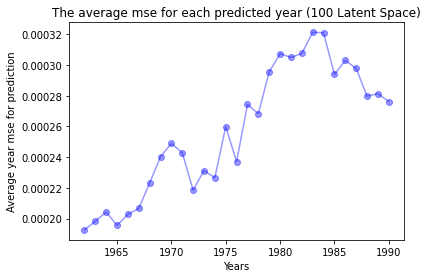

The average mse with testing data5 of prediction is:  0.00025729486651846


In [ ]:
y_decode5, average_mse5, test_mse5 = iterative_prediction(first_test_data5, rest_test_data5, original_test_data5, 1961)
print("The average mse with testing data5 of prediction is: ", average_mse5)




> Plot the MSE between the data predicted by the 1961 data for the following 29 years (1962-1990) and the original data



### Data Assimilation



In [ ]:
def VAR_3D(xb,Y,sigma_B,sigma_R): 
    H = np.eye(xb.size)
    B = sigma_B * np.eye(xb.size)
    R = sigma_R * np.eye(Y.size)
    dim_x = xb.size
    #dim_y = Y.size
    Y.shape = (Y.size,1)
    xb1=np.copy(xb)
    xb1.shape=(xb1.size,1)
    K=np.dot(B,np.dot(np.transpose(H),np.linalg.pinv(np.dot(H,np.dot(B,np.transpose(H)))+R)))
    
    #add condition number
    #print('condition number K',np.linalg.norm(K))
    A=np.dot(np.dot((np.eye(dim_x)-np.dot(K,H)),B),np.transpose((np.eye(dim_x)-np.dot(K,H))))+np.dot(np.dot(K,R),np.transpose(K))
    vect=np.dot(H,xb1)
    xa=np.copy(xb1+np.dot(K,(Y-vect)))
    return xa,A

def iterative_prediction_DA(first_year, label_years, original_data, begin_year, sigma_B, sigma_R):
  times = label_years.shape[0]
  predict_years = np.zeros((times, 12, 180))
  this_year = first_year
  obs_year = np.array_split(label_years, times)

  for i in range(times):
    this_year = inner_prediction(this_year)
    if i%5 == 0:
      da,_ = VAR_3D(this_year, obs_year[i], sigma_B, sigma_R)
      this_year = np.reshape(da, (1, 12, 180))
    predict_years[i] = this_year[0]
  y_predict = np.reshape(predict_years, (12*times, 180))
  prediction = y_predict[:,:100]
  prediction = test_gb.inverse_transform(prediction)
  y_decode = decoder.predict(prediction)

  year_mse = []
  pred_year = np.array_split(y_decode, times)
  ori_year = np.array_split(original_data, times)

  for j in range(times):
    this_year_mse = y_mse(pred_year[j], ori_year[j])
    year_mse.append(this_year_mse)
  x = list(range(begin_year+1, begin_year+times+1))
  # plt.scatter(x, year_mse, alpha=0.6)
  plt.plot(x, year_mse,'bo-', alpha=0.4)
  plt.title("The average mse for each predicted year with Data Assimilation(100 Latent Space)")
  plt.xlabel("Years")
  plt.ylabel("Average year mse for prediction")
  plt.show()
  return y_decode, np.mean(year_mse), year_mse


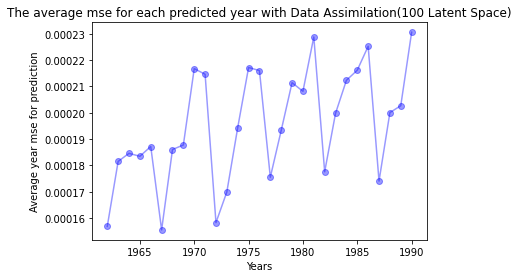

The average mse for testing data4 is:  0.0001953503168445385


In [ ]:
y_decode_da4, average_mse_da4, test_mse_da4 = iterative_prediction_DA(first_test_data, rest_test_data, original_test_data, 1961, 1, 0.1) # combine two figures
print("The average mse for testing data4 is: ", average_mse_da4)

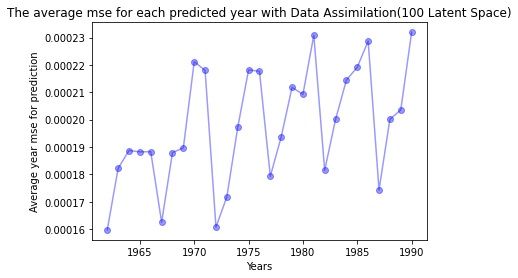

The average mse for testing data5 is:  0.0001976106826257151


In [ ]:
y_decode_da5, average_mse_da5, test_mse_da5 = iterative_prediction_DA(first_test_data5, rest_test_data5, original_test_data5, 1961, 1, 0.1) # combine two figures
print("The average mse for testing data5 is: ", average_mse_da5)


# Final result comparison

In [ ]:
from tensorflow.python.framework.ops import name_from_scope_name
def comp_methods(cae, cae_lstm, cae_lstm_da, begin_year, file_name):
  times = len(cae_lstm)
  cae_pro = []
  sp_cae = np.array_split(cae, 30)
  for i in range(times):
    cae_pro.append(np.mean(sp_cae[i+1]))
  x = list(range(begin_year+1, begin_year+times+1))
  plt.plot(x, cae_pro,'bo-', alpha=0.4, label = "CAE")
  plt.plot(x, cae_lstm,'go-', alpha=0.4, label = "CAE_LSTM")
  plt.plot(x, cae_lstm_da,'ro-', alpha=0.4, label = "CAE_LSTM_DA")
  # plt.title("The average mse for each method (20 Latent Space)")
  plt.xlabel("Years", font1)
  plt.ylabel("Average year MSE", font1)
  plt.ylim([0.000120, 0.000340])
  plt.legend()
  plt.savefig("output_figure/"+str(file_name)+".png",bbox_inches='tight',dpi=300)
  plt.show()
  return np.mean(cae_pro), np.mean(cae_lstm), np.mean(cae_lstm_da)


font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 14,
}

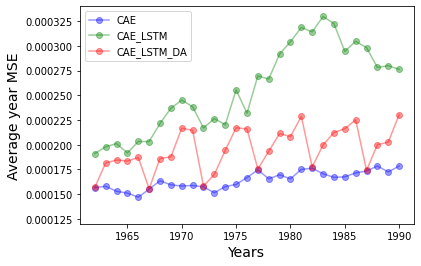

In [ ]:
c4, cl4, cad4 = comp_methods(cae_mse4, test_mse4, test_mse_da4, 1961, "CAE_100_p4")


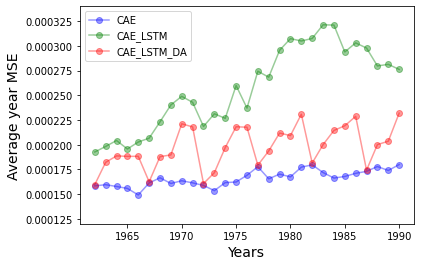

In [ ]:
c5, cl5, cad5 = comp_methods(cae_mse5, test_mse5, test_mse_da5, 1961,"CAE_100_p5")



In [ ]:
def show_comp_methods(original_test_data, cae, cae_lstm, cae_lstm_da, begin_year, interval_year):
  original_test_data = np.reshape(original_test_data,(348, 112, 192))
  cae = np.reshape(cae, (360, 112, 192))
  cae_lstm = np.reshape(cae_lstm, (348, 112, 192))
  cae_lstm_da = np.reshape(cae_lstm_da, (348, 112, 192))
  plt.figure(figsize=(24, 12), facecolor='w')
  monthly_field = np.zeros((112, 192))
  norm = mpl.colors.Normalize(vmin=0.0, vmax=1.0)
  for j in range(3):
    plt.subplot(4, 3, j+1)
    monthly_field = np.zeros((112, 192))
    for i in range(112):
        for k in range(192):
          monthly_field[i,k] = np.array(original_test_data[(begin_year-1)*12+interval_year*j*12][i][k])
    plt.title(f'The {j + 1} oringinal')
    plt.imshow(monthly_field)
    # creating ScalarMappable 
    sm = plt.cm.ScalarMappable(norm=norm) 
    sm.set_array([])
    plt.colorbar(sm)
  for j in range(3):
    plt.subplot(4, 3, j+4)
    monthly_field = np.zeros((112, 192))
    for i in range(112):
        for k in range(192):
          monthly_field[i,k] = np.array(cae[(begin_year+1-1)*12+interval_year*j*12][i][k])
    plt.title(f'The {j + 1} CAE prediction (100)')
    plt.imshow(monthly_field)
    sm = plt.cm.ScalarMappable(norm=norm)
    sm.set_array([])
    plt.colorbar(sm)
  for j in range(3):
    plt.subplot(4, 3, j+7)
    monthly_field = np.zeros((112, 192))
    for i in range(112):
        for k in range(192):
          monthly_field[i,k] = np.array(cae_lstm[(begin_year-1)*12+interval_year*j*12][i][k])
    plt.title(f'The {j + 1} CAE+LSTM prediction (100)')
    plt.imshow(monthly_field)
    sm = plt.cm.ScalarMappable(norm=norm)
    sm.set_array([])
    plt.colorbar(sm)
  for j in range(3):
    plt.subplot(4, 3, j+10)
    monthly_field = np.zeros((112, 192))
    for i in range(112):
        for k in range(192):
          monthly_field[i,k] = np.array(cae_lstm_da[(begin_year-1)*12+interval_year*j*12][i][k])
    plt.title(f'The {j + 1} CAE+LSTM_DA prediction (100)')
    plt.imshow(monthly_field)
    sm = plt.cm.ScalarMappable(norm=norm)
    sm.set_array([])
    plt.colorbar(sm)
  plt.show()



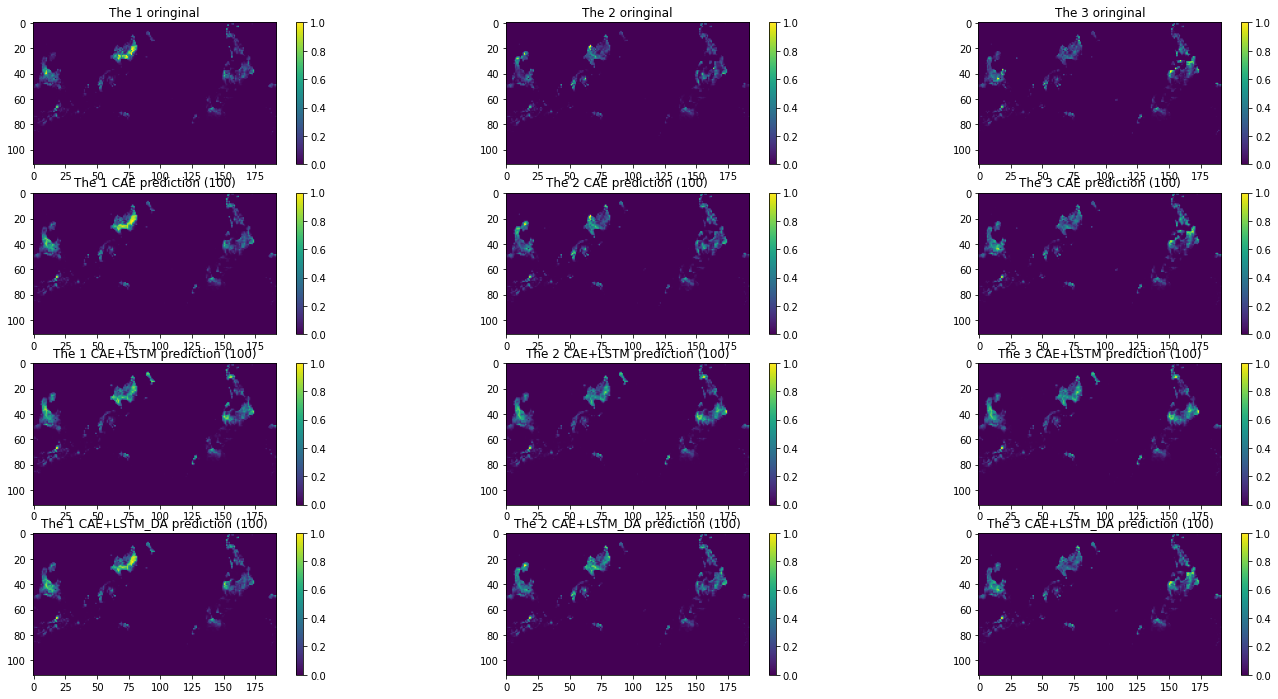

In [ ]:
show_comp_methods(original_test_data5, p5, y_decode5, y_decode_da5, 17, 5)


In [ ]:
def save_comp_methods(original_test_data, cae, cae_lstm, cae_lstm_da, begin_year, interval_year):
  original_test_data = np.reshape(original_test_data,(348, 112, 192))
  cae = np.reshape(cae, (360, 112, 192))
  cae_lstm = np.reshape(cae_lstm, (348, 112, 192))
  cae_lstm_da = np.reshape(cae_lstm_da, (348, 112, 192))
  plt.figure(figsize=(24, 12), facecolor='w')
  for j in range(4):
    plt.figure(figsize=(24, 12), facecolor='w')
    monthly_field = np.zeros((112, 192))
    for i in range(112):
        for k in range(192):
          if j == 0:
            monthly_field[i,k] = np.array(original_test_data[(begin_year-1)*12][~i][k])
          elif j == 2:
            monthly_field[i,k] = np.array(original_test_data[(begin_year-1)*12+interval_year*12][~i][k])
          elif j ==1:
            monthly_field[i,k] = np.array(original_test_data[(begin_year-1)*12+6][~i][k])
          else:
            monthly_field[i,k] = np.array(original_test_data[(begin_year-1)*12+interval_year*12+6][~i][k])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(monthly_field)
    plt.savefig("output_figure/cae_100/orig_"+str(j)+".png", bbox_inches='tight', dpi=300)
  for j in range(4):
    plt.figure(figsize=(24, 12), facecolor='w')
    monthly_field = np.zeros((112, 192))
    for i in range(112):
        for k in range(192):
          if j == 0:
            monthly_field[i,k] = np.array(cae[(begin_year-1)*12][~i][k])
          elif j == 2:
            monthly_field[i,k] = np.array(cae[(begin_year-1)*12+interval_year*12][~i][k])
          elif j ==1:
            monthly_field[i,k] = np.array(cae[(begin_year-1)*12+6][~i][k])
          else:
            monthly_field[i,k] = np.array(cae[(begin_year-1)*12+interval_year*12+6][~i][k])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(monthly_field)
    plt.savefig("output_figure/cae_100/cae_"+str(j)+".png",bbox_inches='tight', dpi=300)
  for j in range(4):
    plt.figure(figsize=(24, 12), facecolor='w')
    monthly_field = np.zeros((112, 192))
    for i in range(112):
        for k in range(192):
          if j == 0:
            monthly_field[i,k] = np.array(cae_lstm[(begin_year-1)*12][~i][k])
          elif j == 2:
            monthly_field[i,k] = np.array(cae_lstm[(begin_year-1)*12+interval_year*12][~i][k])
          elif j ==1:
            monthly_field[i,k] = np.array(cae_lstm[(begin_year-1)*12+6][~i][k])
          else:
            monthly_field[i,k] = np.array(cae_lstm[(begin_year-1)*12+interval_year*12+6][~i][k])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(monthly_field)
    plt.savefig("output_figure/cae_100/lstm_"+str(j)+".png",bbox_inches='tight', dpi=300)
  for j in range(4):
    plt.figure(figsize=(24, 12), facecolor='w')
    monthly_field = np.zeros((112, 192))
    for i in range(112):
        for k in range(192):
          if j == 0:
            monthly_field[i,k] = np.array(cae_lstm_da[(begin_year-1)*12][~i][k])
          elif j == 2:
            monthly_field[i,k] = np.array(cae_lstm_da[(begin_year-1)*12+interval_year*12][~i][k])
          elif j ==1:
            monthly_field[i,k] = np.array(cae_lstm_da[(begin_year-1)*12+6][~i][k])
          else:
            monthly_field[i,k] = np.array(cae_lstm_da[(begin_year-1)*12+interval_year*12+6][~i][k])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(monthly_field)
    plt.savefig("output_figure/cae_100/la_"+str(j)+".png",bbox_inches='tight', dpi=300)
  plt.show()


In [ ]:
save_comp_methods(original_test_data, p4, y_decode4, y_decode_da4, 22, 5)


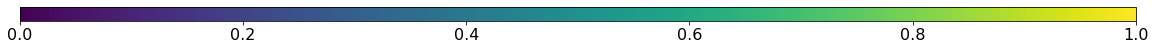

In [ ]:
def colorbar():
    fig, ax = plt.subplots(figsize=(20, 0.5))
    fig.subplots_adjust(bottom=0.5)

    norm = mpl.colors.Normalize(vmin=0.0, vmax=1.0)
    fig.colorbar(
        mpl.cm.ScalarMappable(norm=norm),
        cax=ax,
        orientation="horizontal"
    )
    plt.xticks(fontsize=16)
    fig.savefig("output_figure/colorbar",bbox_inches='tight', dpi=300)
colorbar()